# Urbanity
Welcome to the example notebook!

In [3]:
import copy
import pickle
from pathlib import Path

import yaml
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

import utils
from urbanity import download as ud
from urbanity import Segments

# Uncomment the below to get interactive matplotlib plots in a new window
# %matplotlib qt 

In [4]:
greenspace_tags = {
    "tourism": "camp_site",
    "landuse": "cemetery",
    "leisure": "common",
    "leisure": "dog_park",
    "natural": "scrub",
    "natural": "fell",
    "landuse": "forest",
    "leisure": "garden",
    "landuse": "greenfield",
    "amenity": "graveyard",
    "natural": "grassland",
    "natural": "heath",
    "landuse": "meadow",
    "natural": "moor",
    "leisure": "nature_reserve",
    "leisure": "park",
    "landuse": "recreation_ground",
    "natural": "wood",
}

## Setup

In [8]:
location = "the glebe, ottawa"
savefolder = Path("./data/glebe")
proj_crs = "EPSG:3347"

In [9]:
if not savefolder.exists(): # Download everything new
    # Get geographies
    boundary = ud.download_osm_boundary(location, savefolder)
    network = ud.download_osm_network(boundary, savefolder)
    
    # Get building data from openstreetmap
    osm_buildings = ud.download_osm_buildings(boundary, savefolder)

    # Get building data from microsoft (contains useful info like building height)
    ms_buildings = ud.download_ms_buildings(boundary, savefolder)

    # Get greenspace from openstreetmap
    greenspace = ud.download_osm_generic(boundary, greenspace_tags, savefolder, "greenspace")

    # Generate segments
    segs = Segments.from_network(network, proj_crs)

else: # Load cached files
    # Make typing easier
    fname = lambda name: savefolder / (savefolder.stem + f"_{name}.geojson")

    # Load downloaded files
    boundary = gpd.read_file(fname("boundary")).iloc[0]["geometry"]
    network = utils.input_to_geodf(fname("road_network"))
    osm_buildings = utils.input_to_geodf(fname("osm_buildings"))
    ms_buildings = utils.input_to_geodf(fname("ms_buildings"))
    greenspace = utils.input_to_geodf(fname("osm_greenspace"))

    # Generate segments
    segs = Segments.from_network(network, proj_crs)

Segmenting road network... Done


## Adding Polygon Features
You don't have to remove green space if you don't want to :)

In [11]:
city = copy.deepcopy(segs)

<Axes: >

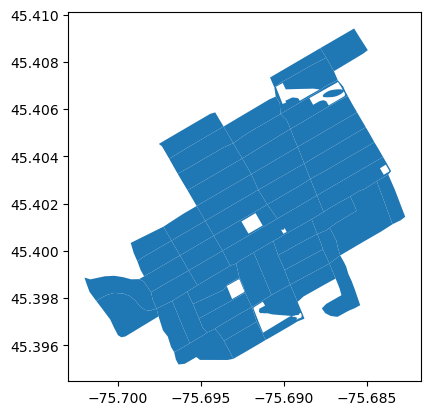

In [12]:
# Removing green space
city = city.subtract_polygons(greenspace)
city.segments.plot(legend=True)

In [13]:
# Calculating built areas
city.segments["area"] = city.segments["geometry"].to_crs(city.proj_crs).area
city = city.subtract_polygons(osm_buildings)

city.segments["unbuilt_area"] = city.segments["geometry"].to_crs(proj_crs).area
city.segments["building_area"] = city.segments["area"] - city.segments["unbuilt_area"]
city.segments["built_percentage"] = city.segments["building_area"] / city.segments["area"]

In [14]:
# Adding height from microsoft building data
city = city.agg_features(ms_buildings, feature="height", how="mean", fillnan=0)

In [15]:
# Calculating built volume
city.segments["built_vol"] = city.segments["building_area"] * city.segments["height"]

### visualizing features

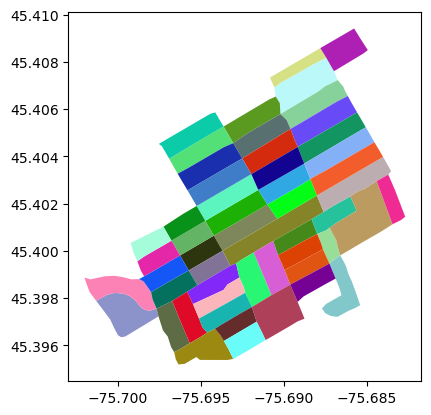

In [40]:
# The original segmentation, randomly colored.
colors = [tuple(np.random.uniform(0, 1, 3)) for _ in range(len(segs.segments))]
segs.segments.plot(color=colors)
plt.show()

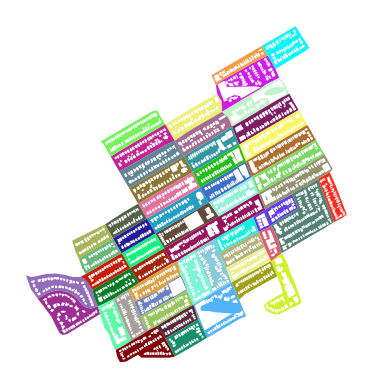

In [38]:
# The segmentation after removing greenspace and buildings
city.segments.plot(color=colors)
plt.axis("off")
plt.show()

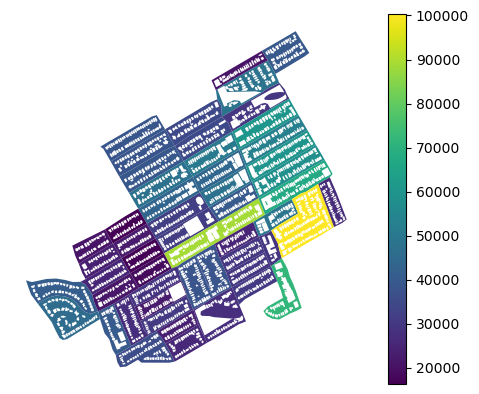

In [41]:
# The built volume of every segment for which there is data
city.segments.plot(column="built_vol", legend=True)
plt.axis("off")
plt.show()

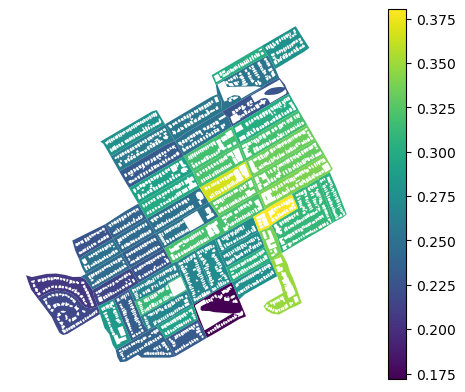

In [42]:
# The built fraction (area developed in a given segment / area of segment)
city.segments.plot(column="built_percentage", legend=True)
plt.axis("off")
plt.show()

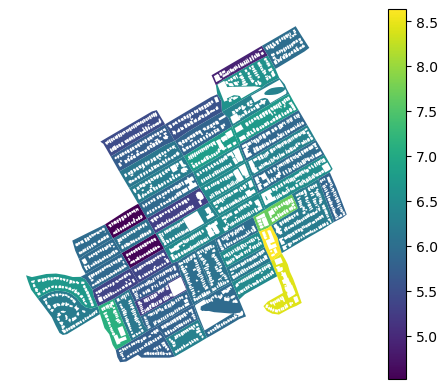

In [45]:
# The built height
# ms_buildings.plot(column="height")
city.segments.plot(column="height", legend=True)
plt.axis("off")
plt.show()

## Determining Infill Potential

In [22]:
# Infill development potential
tiled = city.tiling(15, 2) #15m squares, 2m apart

# Save data
with open(Path(f"{str(savefolder)}/tiled.pkl"), "wb") as f: 
    pickle.dump(tiled, f)

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

The maximum number of single-story buildings in this area is 299


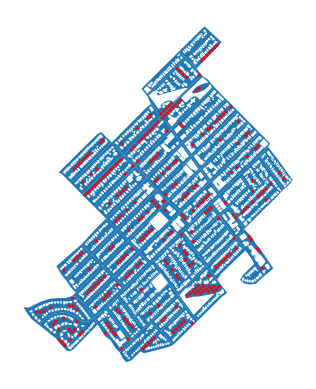

In [46]:
# Plotting
print(f'The maximum number of single-story buildings in this area is {tiled.segments["n_tiles"].sum()}')

ax = tiled.segments["geometry"].plot()
tiled.segments["best_tiling"].plot(ax=ax, color="red")
plt.axis('off')
